In [2]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

# from scipy.stats import binned_statistic_2d
# from scipy.ndimage import gaussian_filter
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
import matplotlib
import matplotlib.cm as cm

# from abacusnbody.analysis.tsc import tsc_parallel
import time

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

# Import packages

sys.path.append('../src/')
# from filter_utils import *
# from SZstacker import SZMapStacker # type: ignore
from utils import ksz_from_delta_sigma

from stacker import SimulationStacker

import illustris_python as il

import yaml
import argparse
from pathlib import Path


In [3]:
# Define configuration explicitly
from tabnanny import verbose

# Extract configuration parameters

redshift = 0.4
loadField = False
saveField = False
radDistance = 1.0
pType = 'gas'
projection = 'yz'

maskHaloes = False
maskRadii = 3.0

sim_type = 'IllustrisTNG'
snapshot = 74
sim_name = 'L50n512_SB35'

# Plotting parameters

plotErrorBars = True
figName = 'DSigma_profiles_yz'

colourmaps = ['hot', 'cool']

t0 = time.time()


In [24]:

# Get colormap
colourmap = matplotlib.colormaps[colourmaps[0]]
colours = [colourmap(0.5)]  # Single color since we have one simulation

if verbose:
    print(f"Processing simulation of type: {sim_type}")

sims = [164, 254]
profiles0_all_sims = []
profiles1_all_sims = []
OmegaBaryons = []
OmegaMatters = []

for s in sims:
    print(f"Processing simulation: {sim_name} simulation {s}")

    stacker = SimulationStacker(s, snapshot, 
                        simType=sim_type)
    stacker_tot = SimulationStacker(s, snapshot, 
                                simType=sim_type)

    OmegaBaryons.append(stacker.header['OmegaBaryon'])
    OmegaMatters.append(stacker.header['Omega0'])

    number_density = [2e-4, 5.4e-4, 6e-4, 1e-3, 2.4e-3]
    ## Corresponding to halo number in 50 Mpc/h box: [25, 68, 75, 125, 300]
    profiles0_all = []
    profiles1_all = []
    for n_density in number_density:
        radii0, profiles0 = stacker.stackMap('gas', filterType='DSigma', minRadius=1.0, maxRadius=6.0,
                                            save=saveField, load=loadField, radDistance=radDistance, halo_number_density=n_density,
                                            projection=projection)
        radii1, profiles1 = stacker_tot.stackMap('total', filterType='DSigma', minRadius=1.0, maxRadius=6.0,
                                                save=saveField, load=loadField, radDistance=radDistance, halo_number_density=n_density,
                                                projection=projection, mask=maskHaloes, maskRad=maskRadii)

        profiles0_all.append(profiles0)
        profiles1_all.append(profiles1)

    profiles0_all_sims.append(profiles0_all)
    profiles1_all_sims.append(profiles1_all)


Processing simulation: L50n512_SB35 simulation 164
Box size: 50000.0 kpc/h , Map size at z=0.4672415175398892: 139.82 arcmin
Processed 0 snapshots, time elapsed: 2.37 seconds
Processed 10 snapshots, time elapsed: 22.46 seconds
Binned statistic time: 32.000396490097046
Number of halos selected: 25
Box size: 50000.0 kpc/h , Map size at z=0.4672415175398892: 139.82 arcmin
Processed 0 snapshots, time elapsed: 1.76 seconds
Processed 10 snapshots, time elapsed: 18.35 seconds
Binned statistic time: 28.914937496185303
Processed 0 snapshots, time elapsed: 2.00 seconds
Processed 10 snapshots, time elapsed: 21.25 seconds
Binned statistic time: 31.06616520881653
Processed 0 snapshots, time elapsed: 0.03 seconds
Processed 10 snapshots, time elapsed: 0.30 seconds
Binned statistic time: 0.4250926971435547
Processed 0 snapshots, time elapsed: 0.00 seconds
Processed 10 snapshots, time elapsed: 0.03 seconds
Binned statistic time: 0.04172158241271973
Number of halos selected: 25
Number of halos selected:

In [25]:
# Save data in a format that handles variable array sizes
save_data = {}
save_data['radii0'] = radii0
save_data['number_density'] = number_density
save_data['sims'] = sims

# Save tau and total profiles separately for each sim and density
for sim_idx, sim_id in enumerate(sims):
    for density_idx, density in enumerate(number_density):
        gas_key = f'gas_sim{sim_id}_density{density_idx}'
        total_key = f'total_sim{sim_id}_density{density_idx}'
        save_data[gas_key] = profiles0_all_sims[sim_idx][density_idx]
        save_data[total_key] = profiles1_all_sims[sim_idx][density_idx]

np.savez(
    f"CAMELS_{sim_name}_gas_DSigma_profiles_low_high_feedback.npz",
    **save_data
)

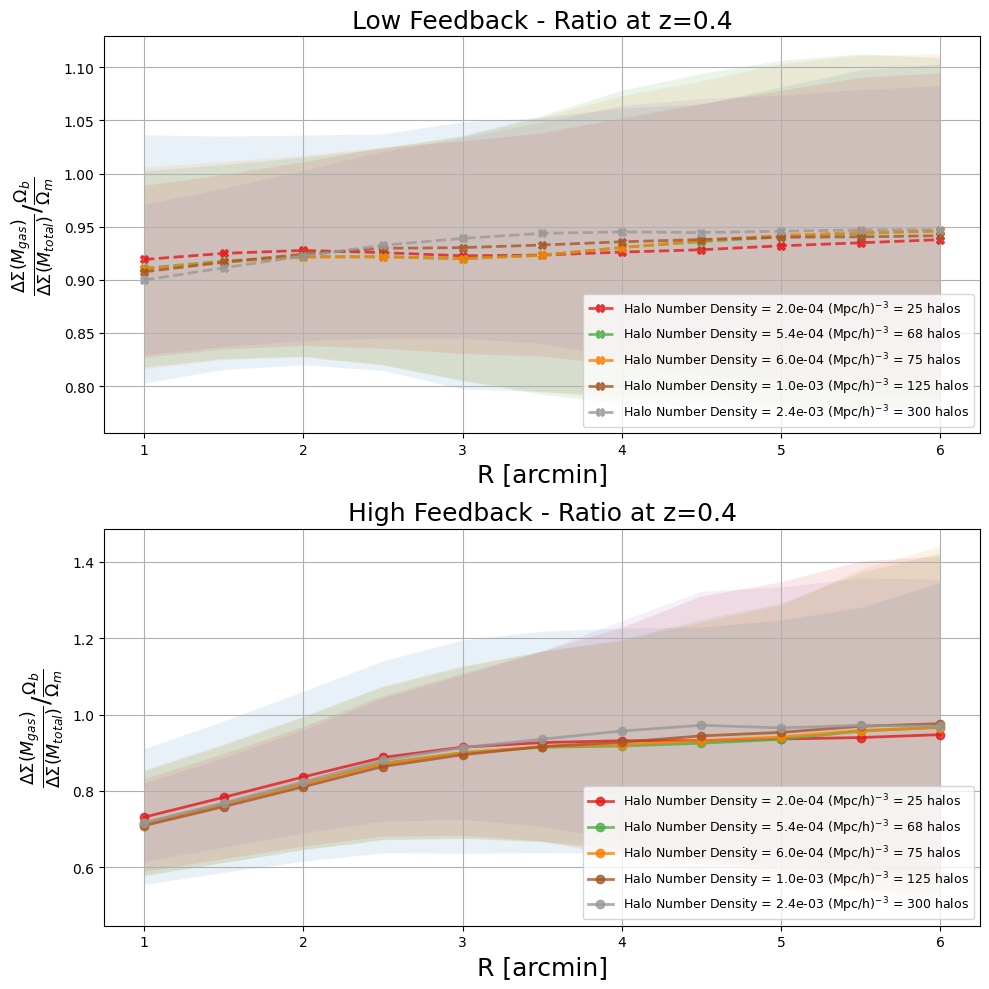

Processing completed in 1664.04 seconds


In [26]:

# Define cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)


# Define cosmology#
# Plotting calculations
T_CMB = 2.7255
v_c = 300000 / 299792458  # velocity over speed of light
num_halos =  [25, 68, 75, 125, 300]
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
colors_list = plt.cm.Set1(np.linspace(0, 1, len(number_density)))

for sim_index in range(len(sims)):
    ax = axes[sim_index]
    profiles0_all = profiles0_all_sims[sim_index]
    profiles1_all = profiles1_all_sims[sim_index]
    OmegaB = OmegaBaryons[sim_index]
    OmegaM = OmegaMatters[sim_index]
    
    for i in range(len(number_density)):
        profiles0 = profiles0_all[i]
        profiles1 = profiles1_all[i]
        # Calculate profile ratios with error propagation
        profiles_plot = np.mean(profiles0, axis=1) / np.mean(profiles1, axis=1) / (OmegaB / OmegaM)

        # Create plot
        # Use different colors for each plot
        color = colors_list[i]
        
        if sim_index == 0:
            marker = 'X'
            ls = '--'
            title_label = 'Low Feedback'
        else:
            marker = 'o'
            ls = '-'
            title_label = 'High Feedback'
            
        ax.plot(radii0 * radDistance, profiles_plot, lw=2, ls=ls, alpha=0.8, marker=marker, color=color, 
                       label=f'Halo Number Density = {number_density[i]:.1e} (Mpc/h)$^{{-3}}$ = {num_halos[i]} halos')

        # Calculate error propagation for ratio
        err0 = np.std(profiles0, axis=1) / np.sqrt(profiles0.shape[1])
        err1 = np.std(profiles1, axis=1) / np.sqrt(profiles1.shape[1])
        profiles_err = np.abs(profiles_plot) * np.sqrt(
            (err0 / np.mean(profiles0, axis=1))**2 + 
            (err1 / np.mean(profiles1, axis=1))**2
        )

        upper = profiles_plot + profiles_err
        lower = profiles_plot - profiles_err
        ax.fill_between(radii0 * radDistance, lower, upper, alpha=0.1)

    # Set labels and formatting for each subplot
    ax.set_xlabel('R [arcmin]', fontsize=18)
    ax.set_ylabel(r'$\frac{\Delta \Sigma (M_{gas})}{\Delta \Sigma (M_{total})}/\frac{\Omega_{b}}{\Omega_{m}} $', fontsize=18)
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True)
    ax.set_title(f'{title_label} - Ratio at z={redshift}', fontsize=18)

fig.tight_layout()
plt.show()

print(f'Processing completed in {time.time() - t0:.2f} seconds')

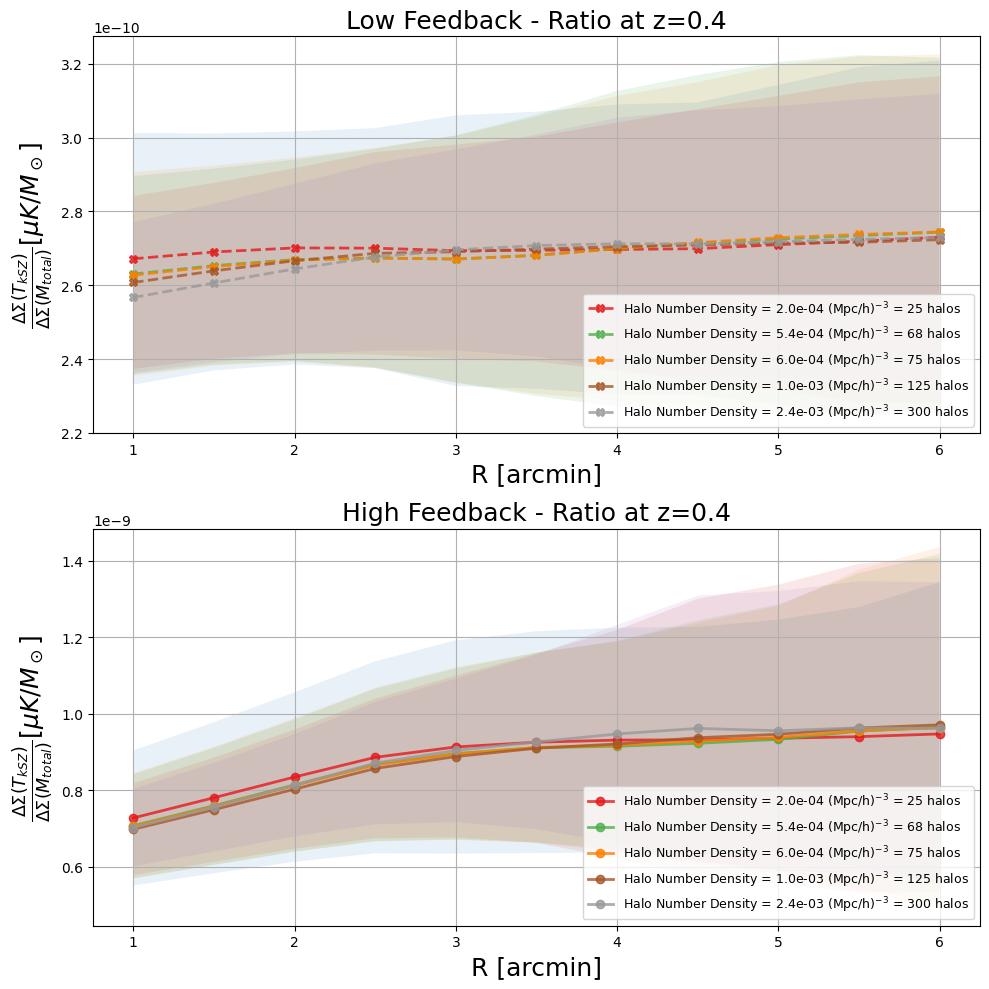

Processing completed in 973.01 seconds


In [18]:

# Define cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

try:
    OmegaBaryon = stacker_tot.header['OmegaBaryon']
except KeyError:
    OmegaBaryon = 0.0456  # Default value for Illustris-1

# Define cosmology#
# Plotting calculations
T_CMB = 2.7255
v_c = 300000 / 299792458  # velocity over speed of light
num_halos =  [25, 68, 75, 125, 300]
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
colors_list = plt.cm.Set1(np.linspace(0, 1, len(number_density)))

for sim_index in range(len(sims)):
    ax = axes[sim_index]
    profiles0_all = profiles0_all_sims[sim_index]
    profiles1_all = profiles1_all_sims[sim_index]
    
    for i in range(len(number_density)):
        profiles0 = profiles0_all[i] * (T_CMB * v_c * 1e6) # convert to microK
        profiles1 = profiles1_all[i]
        # Calculate profile ratios with error propagation
        profiles_plot = np.mean(profiles0, axis=1) / np.mean(profiles1, axis=1)

        # Create plot
        # Use different colors for each plot
        color = colors_list[i]
        
        if sim_index == 0:
            marker = 'X'
            ls = '--'
            title_label = 'Low Feedback'
        else:
            marker = 'o'
            ls = '-'
            title_label = 'High Feedback'
            
        ax.plot(radii0 * radDistance, profiles_plot, lw=2, ls=ls, alpha=0.8, marker=marker, color=color, 
                       label=f'Halo Number Density = {number_density[i]:.1e} (Mpc/h)$^{{-3}}$ = {num_halos[i]} halos')

        # Calculate error propagation for ratio
        err0 = np.std(profiles0, axis=1) / np.sqrt(profiles0.shape[1])
        err1 = np.std(profiles1, axis=1) / np.sqrt(profiles1.shape[1])
        profiles_err = np.abs(profiles_plot) * np.sqrt(
            (err0 / np.mean(profiles0, axis=1))**2 + 
            (err1 / np.mean(profiles1, axis=1))**2
        )

        upper = profiles_plot + profiles_err
        lower = profiles_plot - profiles_err
        ax.fill_between(radii0 * radDistance, lower, upper, alpha=0.1)

    # Set labels and formatting for each subplot
    ax.set_xlabel('R [arcmin]', fontsize=18)
    ax.set_ylabel(r'$\frac{\Delta \Sigma (T_{kSZ})}{\Delta \Sigma (M_{total})} [\mu K/M_\odot]$', fontsize=18)
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True)
    ax.set_title(f'{title_label} - Ratio at z={redshift}', fontsize=18)

fig.tight_layout()
plt.show()

print(f'Processing completed in {time.time() - t0:.2f} seconds')

In [26]:
profiles1.mean(), profiles0.mean()

(np.float64(20312312096.09934), np.float64(0.05483369890348422))

In [32]:
profiles1 = ksz_from_delta_sigma(profiles1 * u.Msun / u.pc**2, redshift, delta_sigma_is_comoving=True, cosmology=cosmo) # convert to kSZ


In [33]:
profiles1.mean(), profiles0.mean()

(np.float64(-15964628126.670963), np.float64(149.55270792180454))